In [2]:
!pip install simpy
!pip install Topsis-Naman-102317229

In [3]:
import simpy,random,numpy as np,pandas as pd

def patient(env,docs,tt,severity,wait):
    arr=env.now
    with docs.request() as req:
        yield req
        wait.append(env.now-arr)
        yield env.timeout(tt*severity)

def generator(env,lam,docs,tt,wait):
    while True:
        yield env.timeout(random.expovariate(lam))
        sev=random.randint(1,3)
        env.process(patient(env,docs,tt,sev,wait))

def run(lam,tt,doc,t=1000):
    env=simpy.Environment()
    docs=simpy.Resource(env,capacity=doc)
    wait=[]
    env.process(generator(env,lam,docs,tt,wait))
    env.run(until=t)
    return np.mean(wait) if wait else 0

rows=[]

for i in range(1000):
    lam=random.uniform(2,15)
    tt=random.uniform(5,20)
    doc=random.randint(1,6)
    avg=run(lam,tt,doc)
    rows.append([lam,tt,doc,avg])

df=pd.DataFrame(rows,columns=["ArrivalRate","TreatmentTime","Doctors","AvgWait"])
df.to_csv("hospital_simulation_data.csv",index=False)
df.head()

,ArrivalRate,TreatmentTime,Doctors,AvgWait
0,3.612443,7.787875,5,454.798927
1,9.507884,9.153653,3,467.556626
2,4.483967,11.572421,2,482.545240
3,6.406987,16.471596,3,471.433869
4,14.991919,6.747930,2,493.641972


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import time

X=df[["ArrivalRate","TreatmentTime","Doctors"]]
y=df["AvgWait"]

Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.2)

mods={
"LR":LinearRegression(),
"DT":DecisionTreeRegressor(),
"RF":RandomForestRegressor(),
"GB":GradientBoostingRegressor(),
"SVR":SVR(),
"KNN":KNeighborsRegressor()
}

res=[]

for n,m in mods.items():
    t1=time.time()
    m.fit(Xtr,ytr)
    trt=time.time()-t1

    t2=time.time()
    p=m.predict(Xte)
    prt=time.time()-t2

    rmse=mean_squared_error(yte,p)**0.5
    r2=r2_score(yte,p)

    res.append([n,rmse,r2,trt,prt])

rdf=pd.DataFrame(res,columns=["Model","RMSE","R2","TrainTime","PredTime"])
rdf.to_csv("results.csv",index=False)
rdf

,Model,RMSE,R2,TrainTime,PredTime
0,LR,13.884290,0.238401,0.034781,0.002649
1,DT,17.242247,-0.174537,0.007230,0.002625
2,RF,12.740471,0.358717,0.595334,0.027600
3,GB,11.907505,0.439829,0.259838,0.002119
4,SVR,13.066774,0.325448,0.042093,0.010299
5,KNN,12.759056,0.356845,0.004339,0.002568


In [5]:
!topsis results.csv 0.35,0.35,0.15,0.15 -,+,-,- topsis_result.csv

done


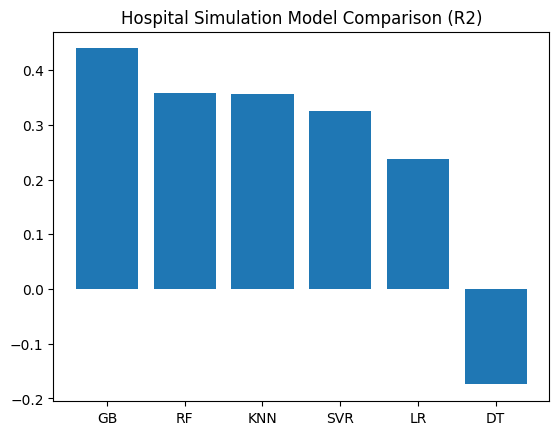

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(rdf.sort_values("R2",ascending=False)["Model"],
        rdf.sort_values("R2",ascending=False)["R2"])
plt.title("Hospital Simulation Model Comparison (R2)")
plt.savefig("model_comparison.png")
plt.show()

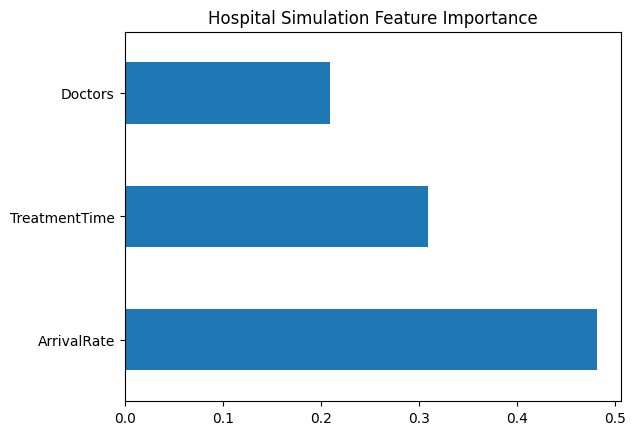

In [7]:
rf=mods["RF"]
imp=pd.Series(rf.feature_importances_,index=X.columns)
imp.plot(kind="barh")
plt.title("Hospital Simulation Feature Importance")
plt.savefig("feature_importance.png")
plt.show()